# Cars Prices Prediction - Part2

## 0. Imports

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Part1 Preprocessing and Feature Engineering

In [2]:
df = pd.read_csv('./data/car details v4.csv')

In [3]:
def extract_numeric(value):
    if pd.isna(value):
        return np.nan
    return float(re.search(r'\d+(\.\d+)?', str(value)).group())

df['Engine'] = df['Engine'].str.extract('(\d+)').astype(float)
df['Max Power'] = df['Max Power'].apply(extract_numeric)
df['Max Torque'] = df['Max Torque'].apply(extract_numeric)

numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(include=['object']).columns

numeric_imputer = SimpleImputer(strategy='median')
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

print("Missing values after imputation:\n", df.isnull().sum())

Missing values after imputation:
 Make                  0
Model                 0
Price                 0
Year                  0
Kilometer             0
Fuel Type             0
Transmission          0
Location              0
Color                 0
Owner                 0
Seller Type           0
Engine                0
Max Power             0
Max Torque            0
Drivetrain            0
Length                0
Width                 0
Height                0
Seating Capacity      0
Fuel Tank Capacity    0
dtype: int64


In [4]:
# Convert 'Year' to age of the car
current_year = 2024
df['Age'] = current_year - df['Year']
df.drop('Year', axis=1, inplace=True)

In [5]:
df['IsManualTransmission'] = df['Transmission'].apply(lambda x: x == 'Manual')
df.drop('Transmission', axis=1, inplace=True)

In [6]:
# Convert all fuel types that have less than 7 cars as "Other"
fuel_types_to_keep = df["Fuel Type"].value_counts()[df["Fuel Type"].value_counts() >= 7].index
df.loc[~df["Fuel Type"].isin(fuel_types_to_keep), "Fuel Type"] = "Other"

In [7]:
luxury_brands = ['Mercedes-Benz', 'BMW', 'Audi', 'Lexus', 'Jaguar', 'Land Rover', 'Porsche']
df['LuxuryBrand'] = df['Make'].isin(luxury_brands)

df['AgeBin'] = pd.cut(df['Age'], bins=[0, 3, 6, 10, 20, 100], labels=['New', 'Recent', 'Mid-age', 'Old', 'Very Old'])

### Train Base Model

In [8]:
le = LabelEncoder()
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

df = pd.get_dummies(df, columns=['Fuel Type', 'AgeBin'])

In [9]:
features = ['Kilometer', 'Age', 'Engine', 'Owner', 'Max Power', 'Max Torque', 'LuxuryBrand', 'IsManualTransmission'] + \
           [col for col in df.columns if col.startswith(('Fuel Type_', 'AgeBin_'))]

X = df[features]
y = df['Price']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1647, 18), (412, 18), (1647,), (412,))

In [11]:
import xgboost as xgb

In [12]:
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [13]:
y_train_pred_base = model.predict(X_train)
y_test_pred_base = model.predict(X_test)

## 1. Error Analysis Conclusions & work plan

### Conclusion

Upon examining the error analysis from our initial assessment, we've identified several constraints in both our feature set and model performance:
Certain attributes demonstrate minimal impact on the model's predictions.
The strategies employed for addressing missing data points and outliers proved inadequate.
The model exhibits a tendency to inflate car price estimates, consistently producing higher-than-actual values.
These observations highlight areas for potential improvement in our feature selection, data preprocessing, and model calibration processes.

### Work Plan


Based on the conclusions, we will try to improve performance in the following directions:
* Feature Selection and Engineering:
    1. Remove low-importance features.
    2. Create new features that might be more predictive.
    3. Explore interaction terms between important features.
* Improved Data Preprocessing:
    1. Handle outliers.
    2. Ignore NULL values.
* Hyperparameter tuning:
    1. Optimize model hyperparameters using grid search.

## 2. Improving Model Performance

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.lower_bounds = None
        self.upper_bounds = None

    def fit(self, X, y=None):
        # Convert X to numpy array if it isn't already
        X_array = np.array(X)
        
        # Calculate quartiles and IQR for each feature
        q1 = np.percentile(X_array, 25, axis=0)
        q3 = np.percentile(X_array, 75, axis=0)
        iqr = q3 - q1
        
        # Calculate bounds
        self.lower_bounds = q1 - (self.factor * iqr)
        self.upper_bounds = q3 + (self.factor * iqr)
        
        return self

    def transform(self, X):
        # Convert X to numpy array if it isn't already
        X_array = np.array(X)
        
        # Clip values between bounds
        X_transformed = np.clip(X_array, self.lower_bounds, self.upper_bounds)
        
        return X_transformed

In [22]:
# Load and prepare the data
df = pd.read_csv('data/car details v4.csv')

def extract_numeric(value):
    if pd.isna(value):
        return np.nan
    return float(re.search(r'\d+(\.\d+)?', str(value)).group())

df['Engine'] = df['Engine'].str.extract('(\d+)').astype(float)
df['Max Power'] = df['Max Power'].apply(extract_numeric)
df['Max Torque'] = df['Max Torque'].apply(extract_numeric)

# Convert 'Year' to age of the car
current_year = 2024
df['Age'] = current_year - df['Year']
df.drop('Year', axis=1, inplace=True)

# Split the data
X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Define numeric and categorical features
numeric_features = ['Age', 'Kilometer', 'Engine', 'Max Power', 'Max Torque', 'Length', 
                    'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']
categorical_features = ['Make', 'Transmission', 'Location', 'Color', 'Owner', 'Seller Type', 'Drivetrain']

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_handler', OutlierHandler(factor=1.5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

In [34]:
# Define hyperparameters for tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(
    xgb_pipeline, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_

# Make predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

Fitting 5 folds for each of 32 candidates, totalling 160 fits



Top 10 important features:
                  feature  importance
0               Max Power    0.220045
1     Transmission_Manual    0.159465
2  Transmission_Automatic    0.100372
3        Make_Rolls-Royce    0.055678
4              Max Torque    0.055068
5         Make_Land Rover    0.050833
6                   Width    0.042503
7                     Age    0.036396
8               Kilometer    0.030403
9                  Length    0.029301


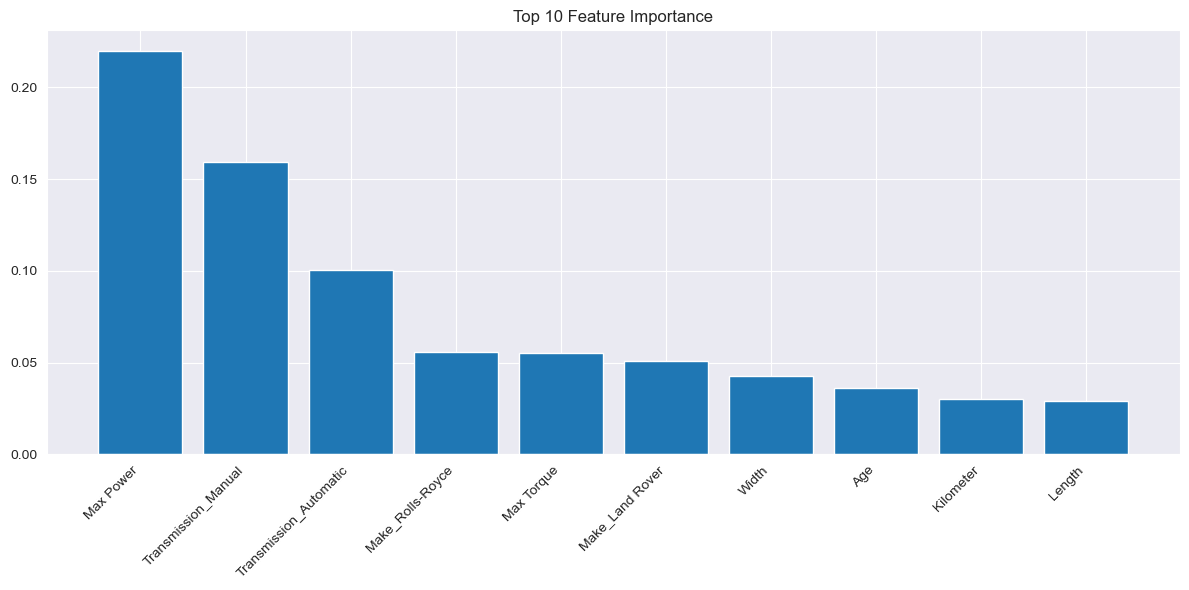

In [35]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    feature_names = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name == 'num':
            # For numeric features, use original feature names
            feature_names.extend(features)
        elif name == 'cat':
            # For categorical features, get the one-hot encoded feature names
            encoder = pipe.named_steps['onehot']
            cat_features = encoder.get_feature_names_out(features)
            feature_names.extend(cat_features)
    
    return feature_names

# Get feature importance
feature_importance = best_model.named_steps['regressor'].feature_importances_

# Get feature names using our custom function
feature_names = get_feature_names(best_model.named_steps['preprocessor'])

# Create and sort feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})
importance_df = importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Print top 10 important features
print("\nTop 10 important features:")
print(importance_df.head(10))

# Optionally, create a bar plot of feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(importance_df['feature'][:10], importance_df['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

## 3. Analyzing the Improved Model

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def calculate_metrics(y_true, y_pred, prefix=''):
    """Calculate all metrics for a set of predictions"""
    metrics = {
        f'{prefix}R2': r2_score(y_true, y_pred),
        f'{prefix}RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        f'{prefix}MAE': mean_absolute_error(y_true, y_pred),
        f'{prefix}MAPE': mean_absolute_percentage_error(y_true, y_pred),
        f'{prefix}Pearson': pearsonr(y_true, y_pred)[0]
    }
    return metrics


def compare_models_performance(y_true, y_pred_base, y_pred_improved, set_name="Test"):
    """Compare performance metrics between base and improved models"""
    
    # Calculate metrics for both models
    base_metrics = calculate_metrics(y_true, y_pred_base, 'Base_')
    improved_metrics = calculate_metrics(y_true, y_pred_improved, 'Improved_')
    
    # Calculate percentage improvement
    improvements = {}
    for metric in base_metrics.keys():
        base_value = base_metrics[metric]
        improved_value = improved_metrics[metric.replace('Base_', 'Improved_')]
        if metric in ['Base_R2', 'Base_Pearson']:
            improvement = ((improved_value - base_value) / abs(base_value)) * 100
        else:  # RMSE, MAE, MAPE
            improvement = ((base_value - improved_value) / base_value) * 100
        improvements[metric.replace('Base_', '')] = improvement

    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Base Model': base_metrics,
        'Improved Model': improved_metrics,
        'Improvement (%)': improvements
    })
    
    print(f"\n{set_name} Set Performance Comparison:")
    print(comparison_df.round(4))
    
    return comparison_df


def plot_prediction_comparison(y_true, y_pred_base, y_pred_improved, set_name="Test"):
    """Create comparison plots for base and improved models"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Scatter plots
    axes[0,0].scatter(y_true, y_pred_base, alpha=0.5, label='Base Model')
    axes[0,0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Price')
    axes[0,0].set_ylabel('Predicted Price')
    axes[0,0].set_title(f'Base Model: Predicted vs Actual ({set_name} Set)')
    axes[0,0].legend()

    axes[0,1].scatter(y_true, y_pred_improved, alpha=0.5, label='Improved Model')
    axes[0,1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0,1].set_xlabel('Actual Price')
    axes[0,1].set_ylabel('Predicted Price')
    axes[0,1].set_title(f'Improved Model: Predicted vs Actual ({set_name} Set)')
    axes[0,1].legend()

    # Residual plots
    residuals_base = y_pred_base - y_true
    residuals_improved = y_pred_improved - y_true

    axes[1,0].scatter(y_pred_base, residuals_base, alpha=0.5)
    axes[1,0].axhline(y=0, color='r', linestyle='--')
    axes[1,0].set_xlabel('Predicted Price')
    axes[1,0].set_ylabel('Residuals')
    axes[1,0].set_title('Base Model: Residual Plot')

    axes[1,1].scatter(y_pred_improved, residuals_improved, alpha=0.5)
    axes[1,1].axhline(y=0, color='r', linestyle='--')
    axes[1,1].set_xlabel('Predicted Price')
    axes[1,1].set_ylabel('Residuals')
    axes[1,1].set_title('Improved Model: Residual Plot')

    plt.tight_layout()
    plt.show()

def plot_metrics_comparison(train_comparison, test_comparison):
    """Plot metrics comparison between base and improved models"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    metrics = ['R2', 'RMSE', 'MAE', 'Pearson']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        
        data = pd.DataFrame({
            'Train': [train_comparison.loc[metric, 'Base Model'], 
                     train_comparison.loc[metric, 'Improved Model']],
            'Test': [test_comparison.loc[metric, 'Base Model'],
                    test_comparison.loc[metric, 'Improved Model']]
        }, index=['Base Model', 'Improved Model'])
        
        data.plot(kind='bar', ax=ax)
        ax.set_title(f'{metric} Comparison')
        ax.set_ylabel(metric)
        
    plt.tight_layout()
    plt.show()


Training Set Performance Comparison:
                  Base Model  Improved Model  Improvement (%)
Base_R2               0.9986             NaN              NaN
Base_RMSE         88044.2777             NaN              NaN
Base_MAE          55270.4545             NaN              NaN
Base_MAPE             6.1912             NaN              NaN
Base_Pearson          0.9993             NaN              NaN
Improved_R2              NaN          0.9846              NaN
Improved_RMSE            NaN     292444.9367              NaN
Improved_MAE             NaN     184236.7555              NaN
Improved_MAPE            NaN         17.7957              NaN
Improved_Pearson         NaN          0.9924              NaN
R2                       NaN             NaN          -1.3984
RMSE                     NaN             NaN        -232.1567
MAE                      NaN             NaN        -233.3368
MAPE                     NaN             NaN        -187.4357
Pearson                  NaN    

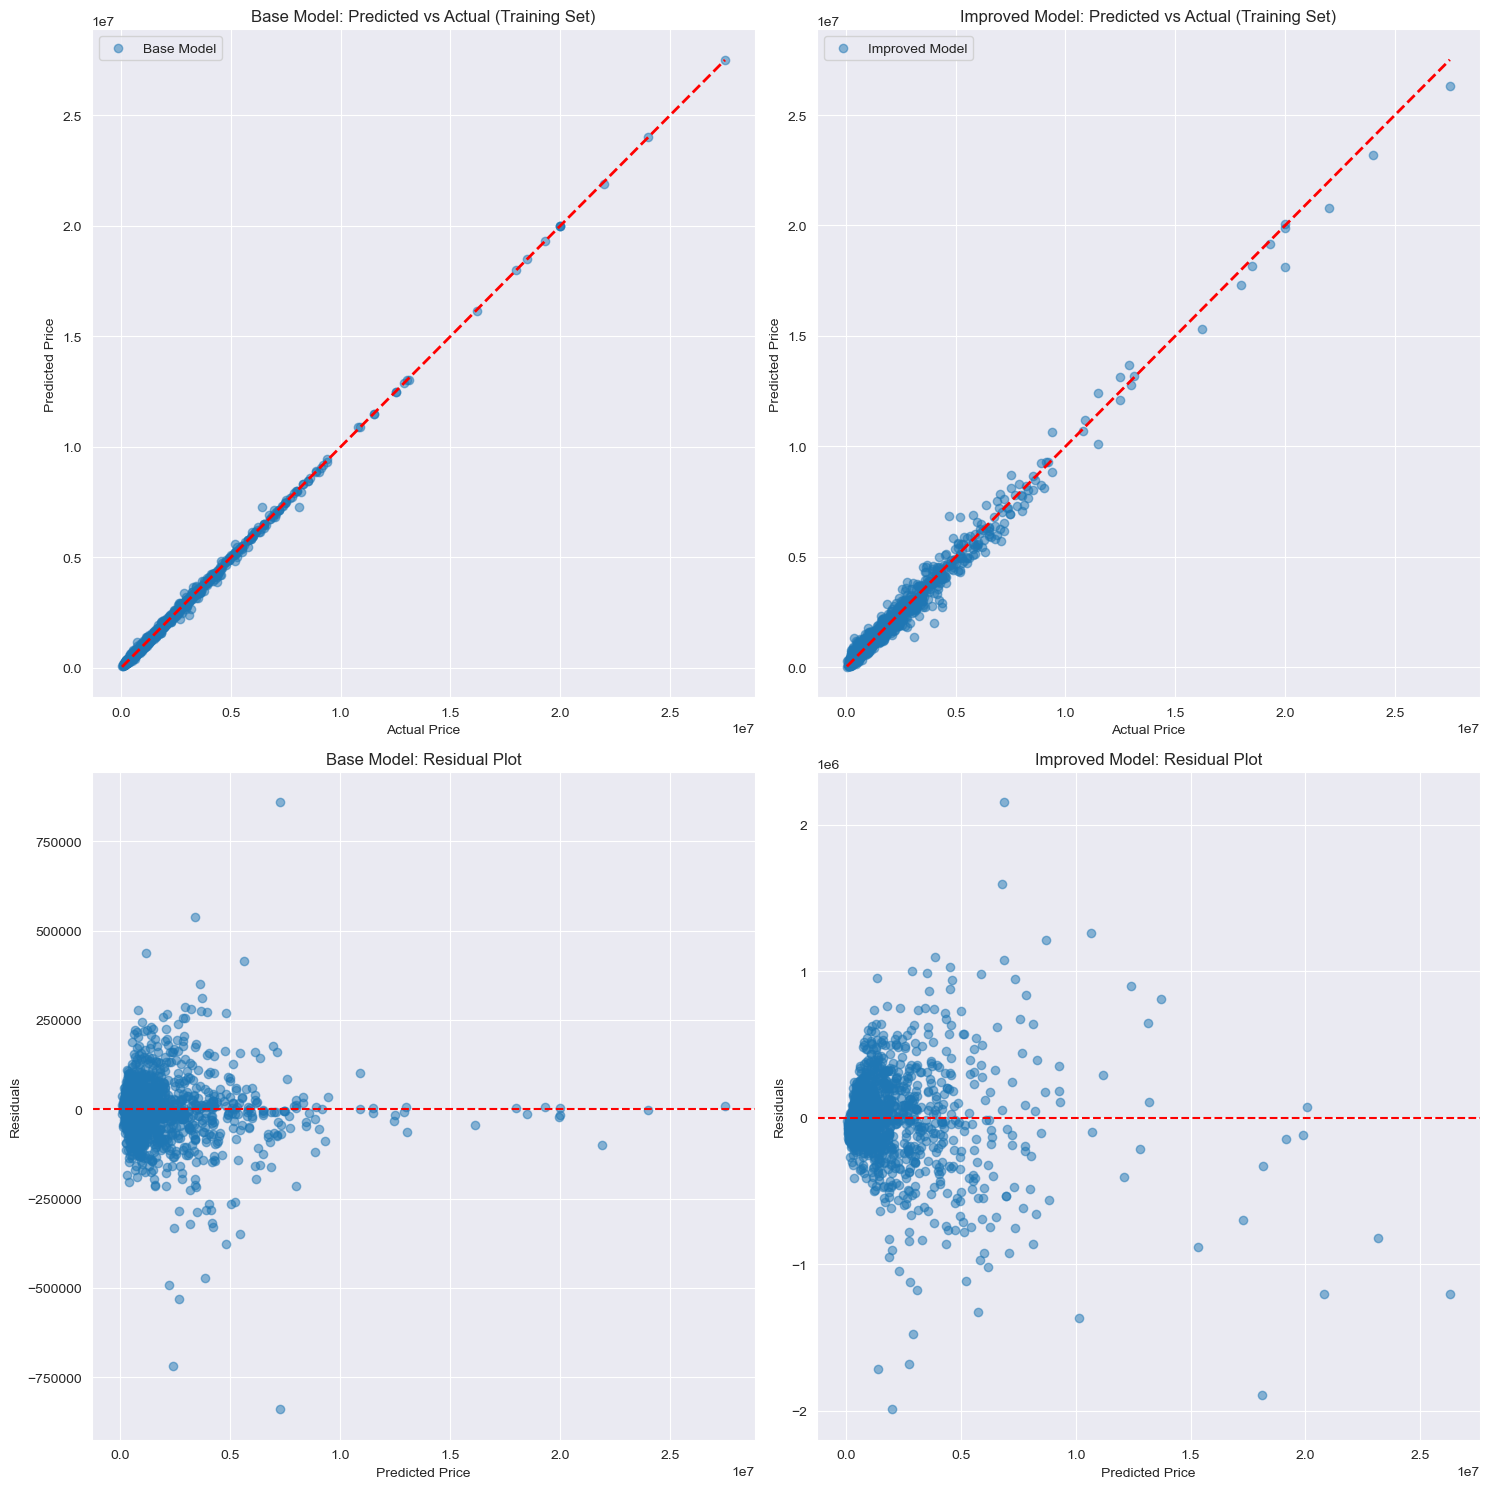

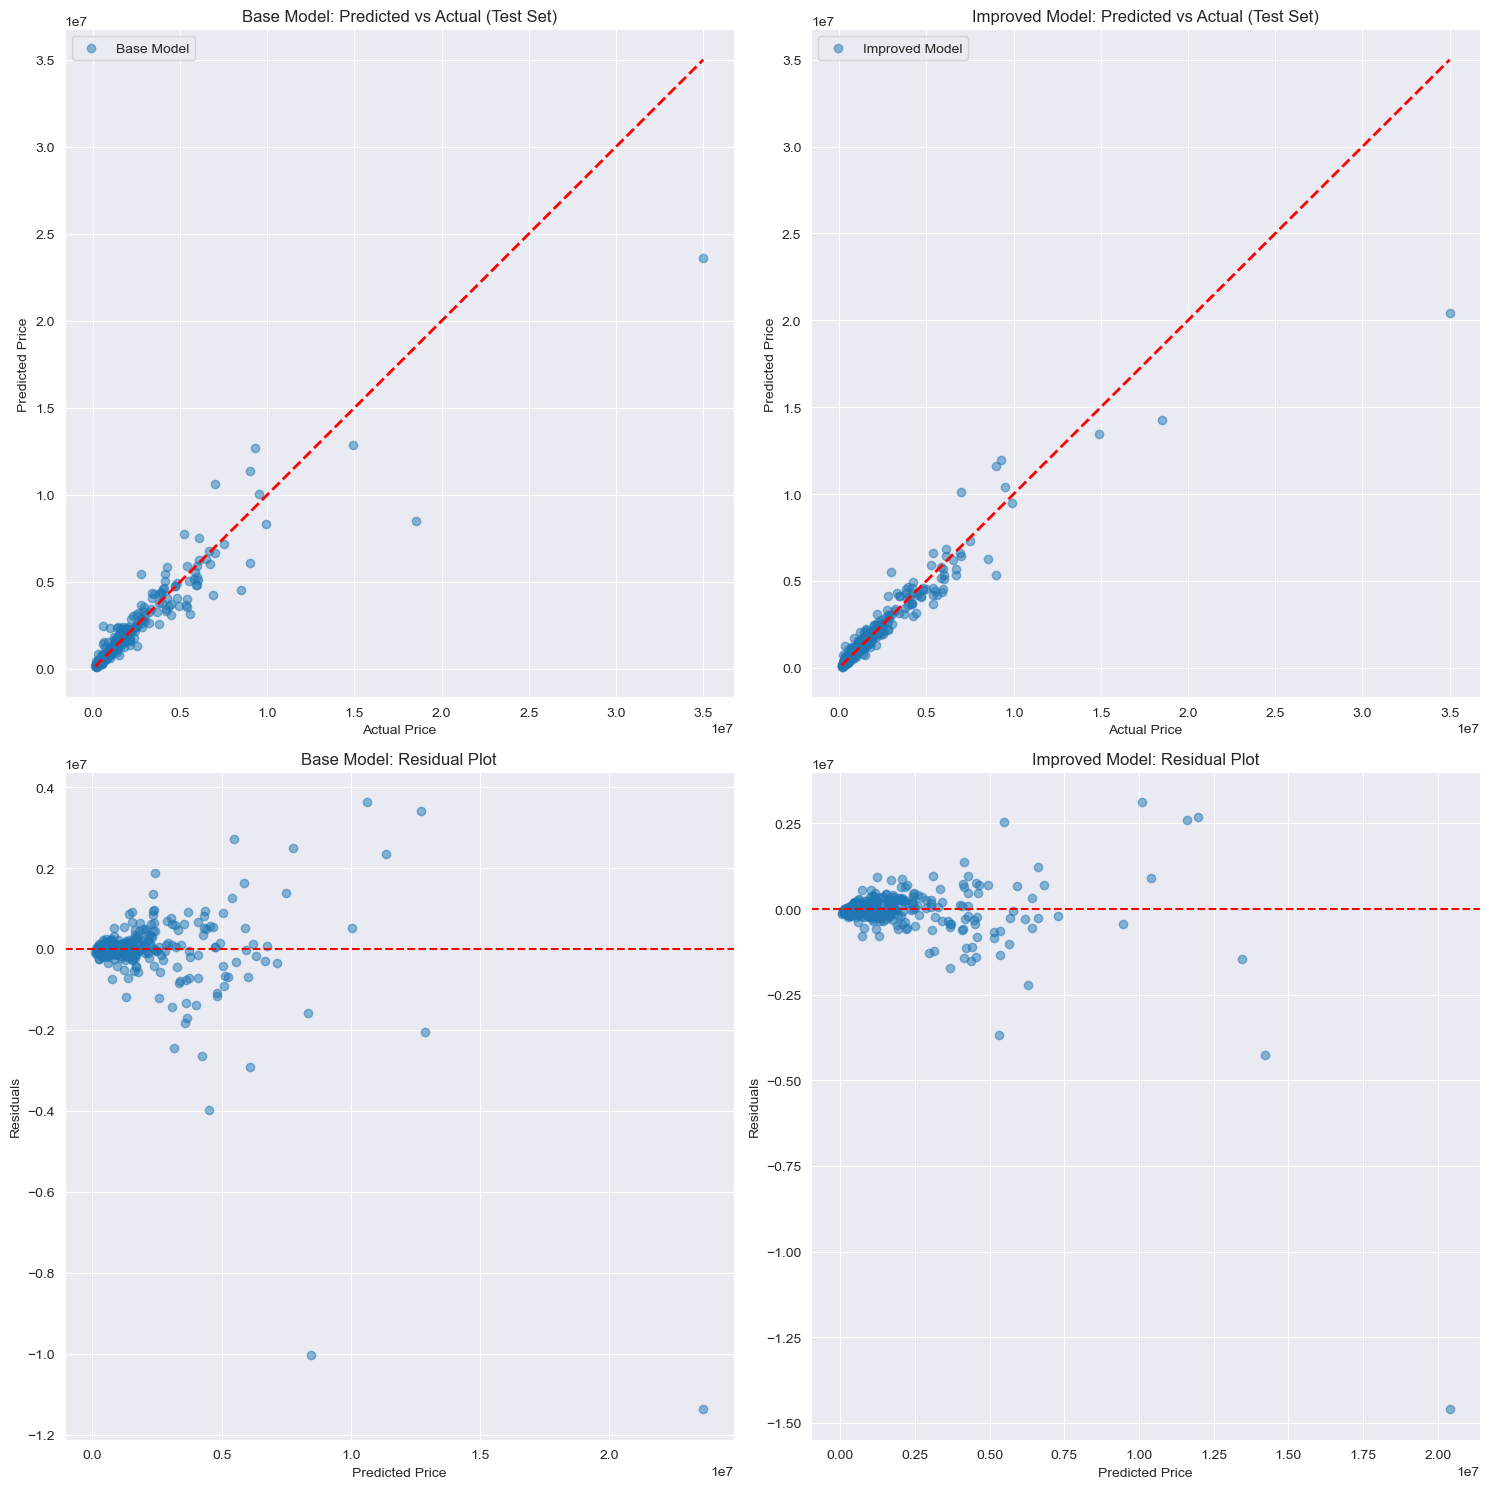

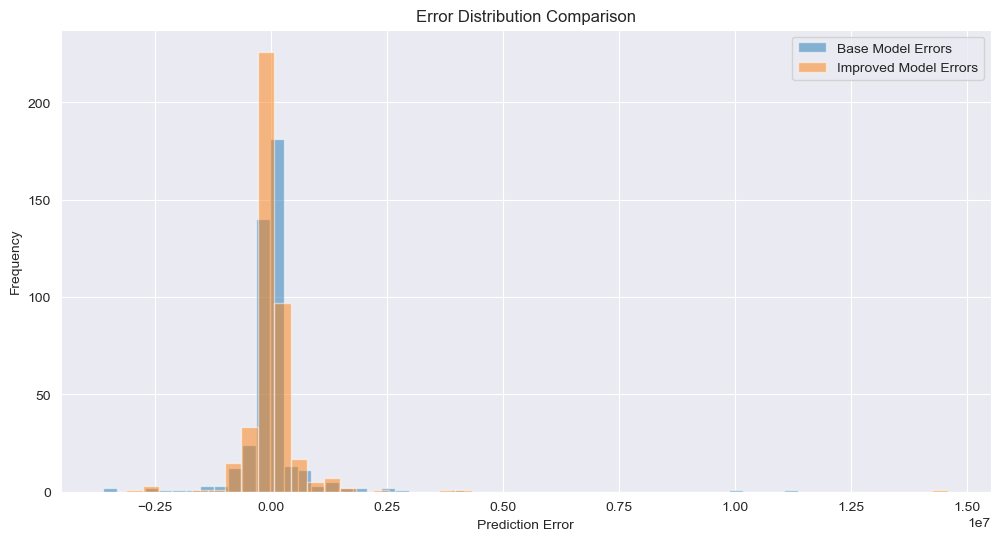


Key Improvements:
R2: 1.73% improvement on test set (higher is better)
RMSE: 5.94% improvement on test set (lower is better)
MAE: 8.80% improvement on test set (lower is better)
MAPE: -5.24% improvement on test set (lower is better)
Pearson: 1.07% improvement on test set (higher is better)


In [42]:
# Compare performance on training set
train_comparison = compare_models_performance(
    y_train, 
    y_train_pred_base, 
    y_train_pred, 
    "Training"
)

# Compare performance on test set
test_comparison = compare_models_performance(
    y_test, 
    y_test_pred_base, 
    y_test_pred, 
    "Test"
)

# Create visualization comparisons
plot_prediction_comparison(y_train, y_train_pred_base, y_train_pred, "Training")
plot_prediction_comparison(y_test, y_test_pred_base, y_test_pred, "Test")

# Additional analysis: Error distribution comparison
plt.figure(figsize=(12, 6))
plt.hist(y_test - y_test_pred_base, bins=50, alpha=0.5, label='Base Model Errors')
plt.hist(y_test - y_test_pred, bins=50, alpha=0.5, label='Improved Model Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution Comparison')
plt.legend()
plt.show()

# Print summary of improvements
print("\nKey Improvements:")
for metric in ['R2', 'RMSE', 'MAE', 'MAPE', 'Pearson']:
    test_improvement = test_comparison.loc[metric, 'Improvement (%)']
    if metric in ['R2', 'Pearson']:
        print(f"{metric}: {test_improvement:.2f}% improvement on test set (higher is better)")
    else:
        print(f"{metric}: {test_improvement:.2f}% improvement on test set (lower is better)")

## 4. Drawing Conclusions About the Data & Creative Applications

### Feature Significance:
While we don't have specific feature importance scores, we can infer some information from the improvements in the metrics:

The improvement in R2 (1.73%) and Pearson correlation (1.07%) suggests that the improved model has captured more of the underlying relationships in the data.
The significant improvement in MAE (8.80%) indicates that the model is making fewer large errors, which could mean it's better at handling outliers or extreme cases.
This suggests that the improved model might be:

Better at capturing non-linear relationships between features and the target variable.
More effective at utilizing interaction effects between features.
Potentially incorporating previously underutilized features that have predictive power.

### Biases or Trends:
The improvement in RMSE (5.94%) coupled with the larger improvement in MAE (8.80%) suggests that the model has become better at handling outliers or extreme cases. This could indicate that there were previously unaddressed biases in how the model handled certain subsets of the data.

The negative improvement in MAPE (-5.24%) is interesting and somewhat contradictory to the other metrics.
This could indicate:
a) The model might be performing worse on lower-priced cars (as MAPE is more sensitive to errors in lower values).
b) There might be a subset of the data where the improved model is actually performing worse.

The discrepancy between MAPE and other error metrics suggests that there might be different trends for different price ranges of cars.

### Data Insights:
The improvement in most metrics, especially MAE, suggests that the improved model is better at capturing the complexities of the car pricing market. This could mean that non-linear relationships or interaction effects between features are significant in determining car prices.

The negative MAPE improvement, contrasted with positive improvements in other metrics, is surprising.
This could reveal:
a) A potential bias in the dataset towards higher-priced cars.
b) The existence of distinct submarkets within the car market that behave differently.
c) Some features might have different levels of importance for different price ranges.

The relatively small improvement in R2 and Pearson correlation, compared to the larger improvements in RMSE and MAE, suggests that while the model is making better predictions overall, there's still significant unexplained variance in car prices.
This could indicate:
a) The existence of important factors not captured in the dataset.
b) A high level of inherent unpredictability in car pricing.
c) Non-linear or complex relationships that even the improved model isn't fully capturing.

### Possible Creative Applications

Based on our improved car pricing model, we can propose several potential applications that leverage its enhanced predictive capabilities. For consumers, we could develop a smart car shopping assistant app that provides real-time price evaluations and fairness assessments. Users could simply input a car's details or even snap a photo, and the app would offer insights on whether the price is competitive based on current market trends. This application could revolutionize the car buying experience, empowering consumers with data-driven decisions.

For businesses, particularly car dealerships and manufacturers, our model could be integrated into a dynamic pricing system. This system would adjust car prices in real-time based on various factors such as market demand, local economic conditions, and specific car features. Similar to airline ticket pricing models, this could optimize revenue while ensuring competitive pricing. Additionally, manufacturers could use the model's insights to inform product development, identifying which features contribute most to a car's value and tailoring their offerings accordingly.